In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

Maintenant qu'on a à disposition pour chaque pays, data sur le **revenu** et **indice de Gini** (2 variables explicatives) , pour il nous manque la **classe de revenu des parents** (3ème variable explicative). Pour avoir la classe de revenu des parents, il faut le **coefficient d'élasticité** de chaque pays 

*pj: coeff d'élasticité (propre à chaque pays) qui mesure la corrélation entre revenu d'enfant & revenu des parents - mobilité intergénérationnelle**

Ainsi l'enjeu de cette mission consiste à sortir la distribution de probabilité la classe revenu des parents (**c_i_parent**) basé sur classe de revenu des enfants (**c_i_child**) et coeff d'élasticité (**pj**) 

### Ci-après les fonctions pour la Mission 3: 

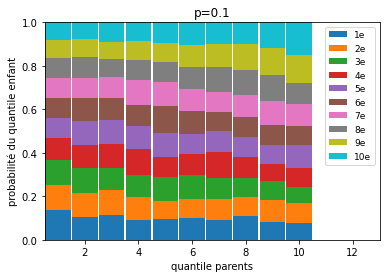

[[0.135 0.103 0.115 0.09  0.095 0.1   0.093 0.11  0.083 0.076]
 [0.119 0.11  0.116 0.107 0.083 0.088 0.096 0.089 0.101 0.091]
 [0.113 0.116 0.101 0.102 0.11  0.112 0.096 0.086 0.086 0.078]
 [0.1   0.107 0.108 0.117 0.095 0.094 0.12  0.095 0.08  0.084]
 [0.094 0.109 0.112 0.106 0.109 0.091 0.094 0.094 0.085 0.106]
 [0.093 0.106 0.101 0.1   0.125 0.109 0.091 0.092 0.095 0.088]
 [0.088 0.093 0.096 0.111 0.109 0.101 0.092 0.102 0.107 0.101]
 [0.093 0.095 0.083 0.092 0.092 0.1   0.112 0.113 0.121 0.099]
 [0.086 0.085 0.077 0.088 0.088 0.102 0.105 0.118 0.124 0.127]
 [0.079 0.076 0.091 0.087 0.094 0.103 0.101 0.101 0.118 0.15 ]]

P(c_i_parent = 8 | c_i_child = 5, pj = 0.1) = 0.095


In [2]:
import scipy.stats as st
import pandas as pd
import numpy as np
from collections import Counter

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend(fontsize= 9)
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

pj = 0.1                             # coefficient d'élasticité du pays j
nb_quantiles = 10           # nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles    # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles)              # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)

c_i_child = 5
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))

#### ici on suppose qu'on est dans le scenario à forte mobilité intergénérationnelle: pj=0.1

#####  fonction *generate_incomes(n, pj)* arrive à répondre Q1 - Q3 

In [3]:
# Q1. générer In_y_parent selon une loi normale.
ln_y_parent = st.norm(0,1).rvs(size=n)  
print(pd.Series(ln_y_parent))

0      -0.536694
1      -0.164913
2      -0.080303
3       1.925688
4       1.068600
          ...   
9995    1.238882
9996   -0.904314
9997   -1.335628
9998   -0.021398
9999    0.482564
Length: 10000, dtype: float64


In [4]:
# Q2. Générez réalisations du terme d'erreur selon une loi normale de moyenne 0 et d'écart-type 1
residues = st.norm(0,1).rvs(size=n)
print(pd.Series(residues))

0      -0.622980
1       0.541549
2       0.066073
3      -0.564668
4       0.092650
          ...   
9995    1.400556
9996    1.099306
9997   -1.143759
9998    0.053301
9999    0.032380
Length: 10000, dtype: float64


In [5]:
# Q1-3: générer les 10000 individus (pj = 0.1)

Income= pd.DataFrame(generate_incomes(n, pj)).transpose()
print(Income)
print(Income.describe())

Income= Income.rename(columns= {0: 'y_child', 1:'y_parents'})
Income.head()

             0          1
0     0.805640   1.493275
1     1.170085   0.687710
2     4.050742   1.289770
3     1.131370   4.789738
4     0.423556   5.114876
...        ...        ...
9995  3.033156   2.103701
9996  0.498743  14.165651
9997  2.497963   1.323000
9998  4.014800   3.101153
9999  4.412637   1.440211

[10000 rows x 2 columns]
                  0             1
count  10000.000000  10000.000000
mean       1.651012      1.648078
std        1.981445      2.168341
min        0.024423      0.024169
25%        0.515035      0.518618
50%        1.008804      1.002586
75%        2.002001      1.934808
max       28.116622     61.852199


,y_child,y_parents
0,0.805640,1.493275
1,1.170085,0.687710
2,4.050742,1.289770
3,1.131370,4.789738
4,0.423556,5.114876



#### Q4.Pour chacun des individus générés, calculez la classe de revenu child (c_i_child) et celui de ses parents (c_i_parent) à partir de revenus child (y_child) et parents (y_parent) 

In_y_parent = (In_y_child - Epsilon)/pj 
y_parent = e (In_y_parent) = np.exp(In_y_parent)

**fonctions: quantiles et compute_quantiles**

In [6]:
#Q4 : calculation de classes revenu ("c_i_child","c_i_parent") à partir de revenu (y_child et y_parents) 

nb_quantiles= 10
n=nb_quantiles*1000

# function Q4: income to class income

def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(Income['y_child'])
    y_parents = pd.Series(Income['y_parents'])
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

compute_quantiles(y_child, y_parents, nb_quantiles)

# (proba conditionnelle n'est pas encore appliquée)

,y_child,y_parents,c_i_child,c_i_parent
0,0.805640,1.493275,5,7
1,1.170085,0.687710,6,4
2,4.050742,1.289770,10,7
3,1.131370,4.789738,6,10
4,0.423556,5.114876,2,10
...,...,...,...,...
9995,3.033156,2.103701,9,8
9996,0.498743,14.165651,3,10
9997,2.497963,1.323000,9,7
9998,4.014800,3.101153,10,9


#### Q5: estimez pour chaque c_i_child la distribution conditionnelle de c_i_parent

#### fonction conditional_distributions

In [7]:
#Q5
nb_quantiles= 10
n=nb_quantiles*1000

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

conditional_distributions(sample, nb_quantiles)

array([[0.135, 0.103, 0.115, 0.09 , 0.095, 0.1  , 0.093, 0.11 , 0.083,
        0.076],
       [0.119, 0.11 , 0.116, 0.107, 0.083, 0.088, 0.096, 0.089, 0.101,
        0.091],
       [0.113, 0.116, 0.101, 0.102, 0.11 , 0.112, 0.096, 0.086, 0.086,
        0.078],
       [0.1  , 0.107, 0.108, 0.117, 0.095, 0.094, 0.12 , 0.095, 0.08 ,
        0.084],
       [0.094, 0.109, 0.112, 0.106, 0.109, 0.091, 0.094, 0.094, 0.085,
        0.106],
       [0.093, 0.106, 0.101, 0.1  , 0.125, 0.109, 0.091, 0.092, 0.095,
        0.088],
       [0.088, 0.093, 0.096, 0.111, 0.109, 0.101, 0.092, 0.102, 0.107,
        0.101],
       [0.093, 0.095, 0.083, 0.092, 0.092, 0.1  , 0.112, 0.113, 0.121,
        0.099],
       [0.086, 0.085, 0.077, 0.088, 0.088, 0.102, 0.105, 0.118, 0.124,
        0.127],
       [0.079, 0.076, 0.091, 0.087, 0.094, 0.103, 0.101, 0.101, 0.118,
        0.15 ]])

In [8]:
#Q5 
# pj=0.1
Cond_distribution = pd.DataFrame(cd)
Cond_distribution.columns = Cond_distribution.columns +1
Cond_distribution['quantile_enfant'] =Cond_distribution.index +1
Cond_distribution.set_index(['quantile_enfant'], inplace=True)

print("Matrice de distribution conditionnelle des probabilités c_i_child vs c_i_parent")
Cond_distribution

# ici les indexes 'quantile_enfant' sont les classes revenus enfants, les colonnes sont les classes revenus parents correspondants

Matrice de distribution conditionnelle des probabilités c_i_child vs c_i_parent


,1,2,3,4,5,6,7,8,9,10
quantile_enfant,,,,,,,,,,
1,0.135,0.103,0.115,0.090,0.095,0.100,0.093,0.110,0.083,0.076
2,0.119,0.110,0.116,0.107,0.083,0.088,0.096,0.089,0.101,0.091
3,0.113,0.116,0.101,0.102,0.110,0.112,0.096,0.086,0.086,0.078
4,0.100,0.107,0.108,0.117,0.095,0.094,0.120,0.095,0.080,0.084
5,0.094,0.109,0.112,0.106,0.109,0.091,0.094,0.094,0.085,0.106
6,0.093,0.106,0.101,0.100,0.125,0.109,0.091,0.092,0.095,0.088
7,0.088,0.093,0.096,0.111,0.109,0.101,0.092,0.102,0.107,0.101
8,0.093,0.095,0.083,0.092,0.092,0.100,0.112,0.113,0.121,0.099
9,0.086,0.085,0.077,0.088,0.088,0.102,0.105,0.118,0.124,0.127


ici l'échantillon est divisée en 10 classes de revenu, donc on a 10*10  estimations de ces probabilités conditionnelles, pour chaque pays


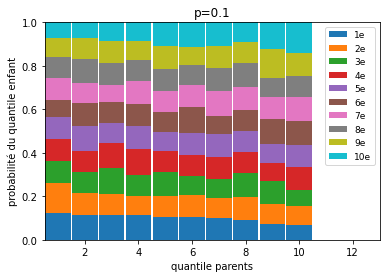

<Figure size 432x288 with 0 Axes>

In [9]:
pj = 0.1                           # coefficient d'élasticité du pays j
nb_quantiles = 10           # nombre de quantiles (nombre de classes de revenu) = 10 
n  = 1000*nb_quantiles   # taille de l'échantillon = 1000*10

def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles)            


plt.savefig('M3 Q123Q6_plot_conditional distribution_pj01.jpg')

#### Q6. pour vérifier la cohérence de code - scénario à faible mobilité: pj = 0.9 
idem que quand le coeff d'élasticité = 0.1, quand il = 0.9, on a 

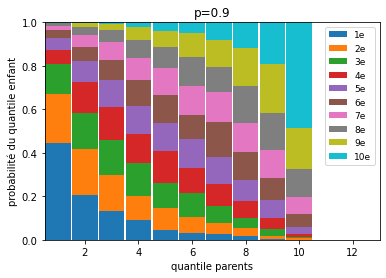

<Figure size 432x288 with 0 Axes>

In [10]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend(fontsize= 9)
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

pj = 0.9                             # coefficient d'élasticité du pays j
nb_quantiles = 10           # nombre de quantiles (nombre de classes de revenu)
n = 1000*nb_quantiles    # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles)              # Cette instruction prendra du temps si nb_quantiles > 10

plt.savefig('M3Q1236_plot_conditionaldistribution_pj09.jpg')

#### Q8: Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de laWID. Pour chaque individu de la Wold Income Distribution, créez-en 499 "clones". La taille devotre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution. 
- 1. Build up the dataframe including info on 114 countries client + corresponding coeff (pj) + Gini indexes: merge gini & coeff & dataWID
- 2. clone 500 times  

In [11]:
#Q8 : dataframe dataWID
dataWID = pd.read_csv('data_cleaned_WID.csv')
dataWID= dataWID.drop(columns=['Unnamed: 0'])
dataWID.describe()
print(dataWID.info())
dataWID.head()
# data_cleaned_WID is the cleaned dataframe 'world_income_distribution.csv' for client countries on 2008

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.9+ KB
None


,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [12]:
# Q8_dataframe Coeff_coeffcient d'électricité 
coeff= pd.read_csv('coeff_pj.csv')
Coeff= coeff.drop(columns=['Unnamed: 0','year'])                  # here all the year 1960-1980
print(Coeff.info())
Coeff

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wbcode     75 non-null     object 
 1   IGEincome  75 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB
None


,wbcode,IGEincome
0,ALB,0.815874
1,AUS,0.275000
2,AUT,0.245267
3,BEL,0.183176
4,BEN,0.855116
...,...,...
70,USA,0.537666
71,UZB,0.496764
72,VNM,0.480000
73,ZAF,0.677000


In [13]:
# Q8_dataframe ginidata
ginidata= pd.read_csv('ginidata.csv', index_col=None).sort_values('country')
print(ginidata.describe())
ginidata_mean=ginidata[['c3','gini']].groupby('c3').mean('gini').reset_index()         # aggfunc by the mean of 'gini' data over years 
ginidata_mean.head()

                 id          year          gini
count  20592.000000  20592.000000  20592.000000
mean   10630.988782   2001.319542     37.281548
std     6145.293483     14.517767      9.416913
min        1.000000   1867.000000     12.100000
25%     5293.750000   1995.000000     30.300000
50%    10639.500000   2005.000000     35.570000
75%    15971.250000   2012.000000     43.462500
max    21253.000000   2020.000000     78.600000


,c3,gini
0,AFG,31.000000
1,AGO,47.095000
2,ALB,31.408889
3,AND,27.097500
4,ARE,35.405000


In [14]:
#Q8 Step1: jointure de 2 df
gini_coeff = ginidata_mean.merge(Coeff, left_on='c3', right_on= 'wbcode').drop(columns=['wbcode'])
gini_coeff 
# inclut pj et gini 


,c3,gini,IGEincome
0,ALB,31.408889,0.815874
1,AUS,33.017782,0.275000
2,AUT,30.632243,0.245267
3,BEL,30.698808,0.183176
4,BEN,41.796667,0.855116
...,...,...,...
67,UGA,40.748387,1.029195
68,USA,40.205324,0.537666
69,UZB,33.486250,0.496764
70,VNM,36.275400,0.480000


In [15]:
#Q8
# step2: jointure de tous ces 3 dataframes 

Co = pd.merge(gini_coeff, dataWID, left_on= 'c3', right_on ='country', how='right').drop(['year_survey', 'c3'], axis=1)  
print(Co.info())
Co=Co.dropna(how='any')
Co

#income: revenu des parents

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gini          6300 non-null   float64
 1   IGEincome     6300 non-null   float64
 2   country       11600 non-null  object 
 3   quantile      11600 non-null  int64  
 4   nb_quantiles  11600 non-null  int64  
 5   income        11600 non-null  float64
 6   gdpppp        11600 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 725.0+ KB
None


,gini,IGEincome,country,quantile,nb_quantiles,income,gdpppp
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0
1,31.408889,0.815874,ALB,2,100,916.66235,7297.0
2,31.408889,0.815874,ALB,3,100,1010.91600,7297.0
3,31.408889,0.815874,ALB,4,100,1086.90780,7297.0
4,31.408889,0.815874,ALB,5,100,1132.69970,7297.0
...,...,...,...,...,...,...,...
11494,64.490000,0.677000,ZAF,96,100,24553.56800,9602.0
11495,64.490000,0.677000,ZAF,97,100,28858.03100,9602.0
11496,64.490000,0.677000,ZAF,98,100,35750.29000,9602.0
11497,64.490000,0.677000,ZAF,99,100,46297.31600,9602.0


In [16]:
# Q8 
#Step 3: cloner tous les individus (pays clientèle) par 500 fois : on a 500 pour chaque c_i_child et chaque country 

Co500 = pd.concat([Co]*500, ignore_index=True)                 # cloner en 500 fois les individus 
Co500= Co500.sort_values(by=['country','quantile'])
print(Co500.info())
Co500=Co500.rename({'quantile': 'quantile_child'}, axis=1)      #here quantile is changed to quantile_child 
Co500.head()

# 500 individus pour chaque c_i_child de chaque pays , donc y a 100*500 individus pour chaque pays 
# 6300*500 = 3150000 rows
# Q8 fini

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150000 entries, 0 to 3149999
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   gini          float64
 1   IGEincome     float64
 2   country       object 
 3   quantile      int64  
 4   nb_quantiles  int64  
 5   income        float64
 6   gdpppp        float64
dtypes: float64(4), int64(2), object(1)
memory usage: 192.3+ MB
None


,gini,IGEincome,country,quantile_child,nb_quantiles,income,gdpppp
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0
6300,31.408889,0.815874,ALB,1,100,728.89795,7297.0
12600,31.408889,0.815874,ALB,1,100,728.89795,7297.0
18900,31.408889,0.815874,ALB,1,100,728.89795,7297.0
25200,31.408889,0.815874,ALB,1,100,728.89795,7297.0


#### Q9: Vous attribuerez aux 500 individus leurs classes c_i_parent conformément aux distributions trouvées précédemment. Ctd. attribution de c_i_parent à chaque observation selon fonctions données

- 1.  Calculate corresponding **conditional distribution (P)** of class income parents based on the class income child that we have in the dataframe of Q8.
- 2. then add onto the dataframe **quantities of every possibility** for class income parents with regard to every class income child 

In [17]:
#Q9: attribution de c_i_parent à chaque observation selon fonctions ('counts')

# pour faciliter la vitesse de calcul, ici on prend ALB pour exemple illustratif

ALB = Co500[Co500['country']=='ALB']
print(ALB.info())
ALB.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 3143799
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gini            50000 non-null  float64
 1   IGEincome       50000 non-null  float64
 2   country         50000 non-null  object 
 3   quantile_child  50000 non-null  int64  
 4   nb_quantiles    50000 non-null  int64  
 5   income          50000 non-null  float64
 6   gdpppp          50000 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 3.1+ MB
None


,gini,IGEincome,country,quantile_child,nb_quantiles,income,gdpppp
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0
6300,31.408889,0.815874,ALB,1,100,728.89795,7297.0
12600,31.408889,0.815874,ALB,1,100,728.89795,7297.0
18900,31.408889,0.815874,ALB,1,100,728.89795,7297.0
25200,31.408889,0.815874,ALB,1,100,728.89795,7297.0


In [18]:
ALB_proba=[]

pj=Co500.loc[Co500['country']=='ALB','IGEincome'].iloc[0]            # coefficient d'élasticité du pays j
nb_quantiles = 100                                                                              # nombre de quantiles (nombre de classes de revenu)
n = 500*nb_quantiles                                                                       # taille de l'échantillon
    
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
for c_i_child in range(100):
    for c_i_parent in range(100):
        p = proba_cond(c_i_parent, c_i_child, cd)
        ALB_proba.extend([c_i_parent+1]*(int(p*500)))        
            

In [19]:
len(ALB_proba)

50000

In [20]:
ALB['proba_quantile_parent']=ALB_proba

ALB.to_csv('M3_final_ex_ALB.csv')
print(ALB.info())
ALB.head()

<ipython-input-20-049235bb7fc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALB['proba_quantile_parent']=ALB_proba


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 3143799
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gini                   50000 non-null  float64
 1   IGEincome              50000 non-null  float64
 2   country                50000 non-null  object 
 3   quantile_child         50000 non-null  int64  
 4   nb_quantiles           50000 non-null  int64  
 5   income                 50000 non-null  float64
 6   gdpppp                 50000 non-null  float64
 7   proba_quantile_parent  50000 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.4+ MB
None


,gini,IGEincome,country,quantile_child,nb_quantiles,income,gdpppp,proba_quantile_parent
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
6300,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
12600,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
18900,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
25200,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1


In [21]:
Co500.loc[Co500['country']=='ALB','IGEincome'].iloc[0]   


0.8158745

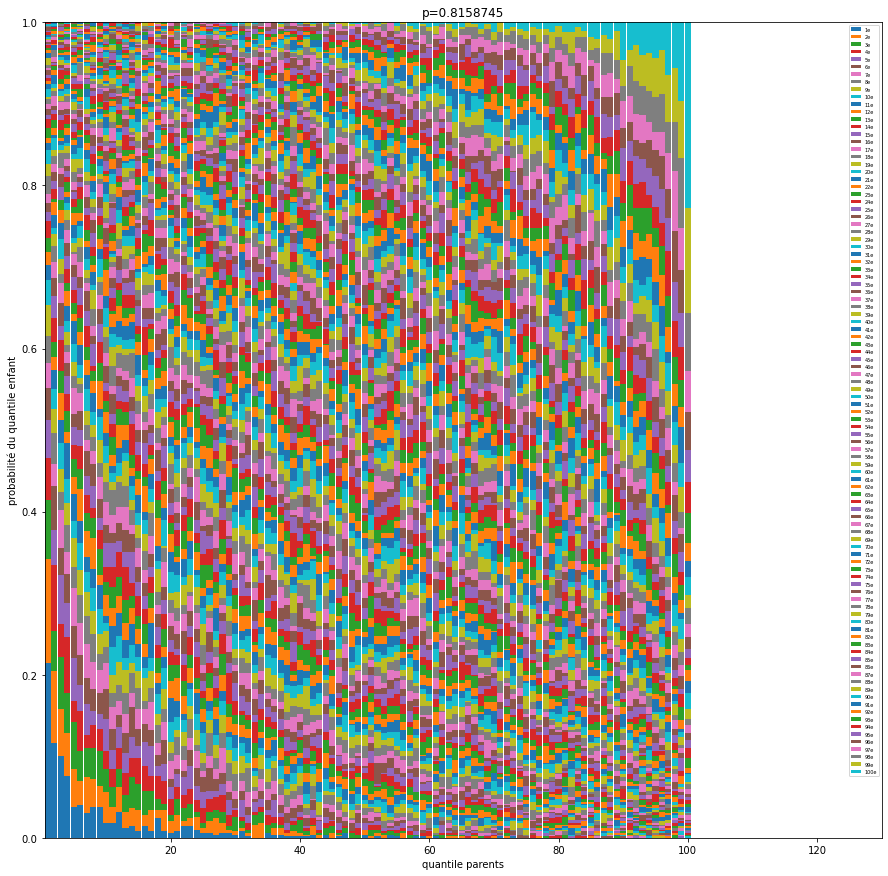


P(c_i_parent = 12 | c_i_child = 16, pj = 0.8158745) = 0.028


<Figure size 432x288 with 0 Axes>

In [22]:
# un exemple d'Albania: ALB

pj=Co500.loc[Co500['country']=='ALB','IGEincome'].iloc[0]   
nb_quantiles = 100                       # classes de revenu = 100                                                       
n = 500*nb_quantiles

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure(figsize= (15,15))
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend(fontsize= 5)
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()
    
plot_conditional_distributions(pj, cd, nb_quantiles)            

plt.savefig('M3 ALB_plot_conditional distribution.jpg')

# cas illustrative: Albania 
c_i_child = 16
c_i_parent = 12
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child,
pj, p))


<font color="1E1EE9"> Pour le pays Albania qui a pour coeff d'élasticité 0.8158745 à faible mobilité, la probabilité pour que la classe revenu parents se situe à la 12ème est 2.8% sachant la classe revenu d'enfant se situe à 16ème/100 classes </font>

In [23]:
print('the number of countries in Co500: ', len(Co500['IGEincome'].unique()))
#Co500['IGEincome'].unique()

the number of countries in Co500:  63


In [24]:
country_list=Co500['country'].unique()
print(len(country_list))
country_list

63


array(['ALB', 'AUT', 'BEL', 'BGD', 'BIH', 'BLR', 'BOL', 'BRA', 'CAN',
       'CHL', 'CHN', 'COL', 'CYP', 'CZE', 'DEU', 'DNK', 'ECU', 'EGY',
       'ESP', 'FIN', 'FRA', 'GBR', 'GHA', 'GIN', 'GRC', 'GTM', 'HRV',
       'IND', 'IRL', 'ITA', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR',
       'LUX', 'LVA', 'MAR', 'MDG', 'MKD', 'MLI', 'MNG', 'MWI', 'MYS',
       'NGA', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PRT', 'RUS',
       'SVK', 'SVN', 'SWE', 'TWN', 'TZA', 'UGA', 'USA', 'VNM', 'ZAF'],
      dtype=object)

In [26]:
#Q9

list_prob=[]

for country in country_list:
    pj=Co500.loc[Co500['country']==country,'IGEincome'].iloc[0]             # coefficient d'élasticité du pays j
    nb_quantiles = 100                                                                              # nombre de quantiles (nombre de classes de revenu)=100
    n = 500*nb_quantiles                                                                           # taille de l'échantillon=500*100 vu qu'on a 500 fois le même individu 
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)
    for c_i_child in range(100):
        for c_i_parent in range(100):
            p = proba_cond(c_i_parent, c_i_child, cd)
            list_prob.extend([c_i_parent+1]*(int(p*500)))        
            
            # p is the probability (in %) for every individual c_i_parent I c_i_child I pj = coeffs, 
            # now that we have 500 clones for every individual, thus p*500 = the number of (c_i_parent) in every probability             
            

In [27]:
len(list_prob)     

3150000

In [28]:
Co500.shape

(3150000, 7)

len(list_prob) = len(Co500), so we can add list_prob onto the Co500

In [30]:
#Q9
Co500['proba_quantile_parent']=list_prob
print(Co500.info())
#Co500= Co500.drop('log_gdpppp', axis=1) 
Co500.to_csv('M3_final_Co500.csv')
Co500.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150000 entries, 0 to 3149999
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   gini                   float64
 1   IGEincome              float64
 2   country                object 
 3   quantile_child         int64  
 4   nb_quantiles           int64  
 5   income                 float64
 6   gdpppp                 float64
 7   proba_quantile_parent  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 216.3+ MB
None


,gini,IGEincome,country,quantile_child,nb_quantiles,income,gdpppp,proba_quantile_parent
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
6300,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
12600,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
18900,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
25200,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1


In [ ]:
#Q10: remove the quantile_child (c_i_child) for further use in M4
Co500_2= Co500.drop(columns= ['quantile_child'])
Co500_2.to_csv('M3_final_Co500_2_droped.csv')

<font color="1E1EE9"> 
    approach retrospective: 
     we know the c_i_child (quantile) and income of child , retrospect to find out the c_i_parent (the revenue classes of their parents) via functions of cd </font>



## M4.1
Appliquez une **ANOVA** sur vos données, en n’incluant comme variable explicative que **le pays** de l’individu. et Analysez la performance du modèle.

In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats

In [ ]:
#Co500_2['log_gdpppp']=np.log(Co500_2['gdpppp'])  
#Co500_2.head()

In [ ]:
#Co500['log_gdpppp']=np.log(Co500['gdpppp'])        # log of natural number 
Co500.head()

<font color="#342EF3"> 
*Why logarithm and why natural logarithm?*
    
Logarithm is the inverse of exponential , that means it's able to transform exponential series into additional series. This makes the calculus easier when it refers to complex situation with multiple variables. 

Natural logarithm is the logarithm to the base of the mathematical constant e, which is approximately 2.718281. Apart from natural log, we can also use log on the base of 10. But natural log is more commonly used in practice. </font>

In [32]:
Q1_ANOVA=Co500.groupby(['country','quantile_child']).mean().reset_index()
Q1_ANOVA.head()

                                                                                                                                                # income représente revenu enfants

,country,quantile_child,gini,IGEincome,nb_quantiles,income,gdpppp,proba_quantile_parent
0,ALB,1,31.408889,0.815875,100.0,728.89795,7297.0,9.276
1,ALB,2,31.408889,0.815875,100.0,916.66235,7297.0,13.972
2,ALB,3,31.408889,0.815875,100.0,1010.91600,7297.0,16.064
3,ALB,4,31.408889,0.815875,100.0,1086.90780,7297.0,18.616
4,ALB,5,31.408889,0.815875,100.0,1132.69970,7297.0,19.760


## ANOVA (analysis of variance) 

On teste la variable pays de l'individu [country] sur le revenu [income] 

Dans notre cas, c'est un One-way ANOVA car il n'y a qu'une seule variable explicative. 


R2 is the percentage of variation in the response that is explained by the model. The higher the R2 value, the better the model fits your data. R2 is always between 0% and 100%.

In [33]:
anova_Q1 = ols('income~country', data=Q1_ANOVA).fit()
anova_Q1.summary()

# why income~country ?  income is the dependent variable Y, country is the X 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     84.42
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:36:52   Log-Likelihood:                -65714.
No. Observations:                6300   AIC:                         1.316e+05
Df Residuals:                    6237   BIC:                         1.320e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2994.8299    824.141      3.634      0.000    1379.229    4610.431
country[T.AUT]  1.364e+04   1165.512     11.705      0.000    1.14e+04    1.59e+04
country[T.BEL]  1.203e+04   1165.512     10.321      0.000    9744.979    1.43e+04
country[T.BGD] -1996.1375   1165.512     -1.713      0.087   -4280.942     288.667
country[T.BIH]  3339.8574   1165.512      2.866      0.004    1055.052    5624.662
country[T.BLR]   926.3336   1165.512      0.795      0.427   -1358.471    3211.139
country[T.BOL]    21.4339   1165.512      0.018      0.985   -2263.371    2306.239
country[T.BRA]  1812.6547   1165.512      1.555      0.120    -472.150    4097.460
country[T.CAN]  2.074e+04   1165.512     17.799      0.000    1.85e+04     2.3e+04
country[T.CHL]  4056.7801   1165.512      3.481      0.001    1771.975    6341.585
country[T.CHN]  -472.0712   1165.512     -0.405      0.685   -2756.876    1812.734
country[T.COL]   552.1754   1165.512      0.474      0.636   -1732.630    2836.980
country[T.CYP]  1.435e+04   1165.512     12.313      0.000    1.21e+04    1.66e+04
country[T.CZE]  5240.4635   1165.512      4.496      0.000    2955.659    7525.268
country[T.DEU]  1.507e+04   1165.512     12.927      0.000    1.28e+04    1.74e+04
country[T.DNK]  1.405e+04   1165.512     12.053      0.000    1.18e+04    1.63e+04
country[T.ECU]   388.9111   1165.512      0.334      0.739   -1895.894    2673.716
country[T.EGY] -1025.2525   1165.512     -0.880      0.379   -3310.057    1259.552
country[T.ESP]  1.012e+04   1165.512      8.685      0.000    7837.358    1.24e+04
country[T.FIN]  1.331e+04   1165.512     11.421      0.000     1.1e+04    1.56e+04
country[T.FRA]  1.531e+04   1165.512     13.140      0.000     1.3e+04    1.76e+04
country[T.GBR]  1.871e+04   1165.512     16.057      0.000    1.64e+04     2.1e+04
country[T.GHA] -2258.2274   1165.512     -1.938      0.053   -4543.032      26.578
country[T.GIN] -2298.8179   1165.512     -1.972      0.049   -4583.623     -14.013
country[T.GRC]  8732.4444   1165.512      7.492      0.000    6447.639     1.1e+04
country[T.GTM]  -852.3551   1165.512     -0.731      0.465   -3137.160    1432.450
country[T.HRV]  4721.6359   1165.512      4.051      0.000    2436.831    7006.441
country[T.IND] -2070.5604   1165.512     -1.777      0.076   -4355.365     214.244
country[T.IRL]  1.472e+04   1165.512     12.626      0.000    1.24e+04     1.7e+04
country[T.ITA]  1.193e+04   1165.512     10.236      0.000    9645.580    1.42e+04
country[T.JOR]    53.8011   1165.512      0.046      0.963   -2231.004    2338.606
country[T.JPN]  1.444e+04   1165.512     12.388      0.000    1.22e+04    1.67e+04
country[T.KAZ]  -755.6801   1165.512     -0.648      0.517   -3040.485    1529.125
country[T.KEN] -2475.5099   1165.512     -2.124      0.034   -4760.315    -190.705
country[T.KG

#### H0 pour ce modèle: le pays (country) n'a pas d'impact sur les revenus (income), ctd. les variances de income de ces différents pays sont similaires / qui que ce soit le pays, les vairances de income sont identiques. 

##### F-stat est petite et La Prob(F-statistic)  - est 0.00, largement inférieure à 5 %. 
##### On rejette donc l'hypothèse H0 (égalité des variances), il existe de grande diversité en terme de variance de différents pays, donc le pays a de l'impact sur les revenus. 

-----

##### R-squared = 0.45 => la variance expliquée par ce modèle est 45%

In [34]:
analyse_country=sm.stats.anova_lm(anova_Q1, typ=2) 
analyse_country

,sum_sq,df,F,PR(>F)
country,3.554930e+11,62.0,84.418151,0.0
Residual,4.236227e+11,6237.0,NaN,NaN


In [35]:
SCE_country=analyse_country.iloc[0,0]
SCR=analyse_country.iloc[1,0]
R2_country=SCE_country/(SCE_country+SCR)
print('sur les revenus, la variance expliquée par pays est:', R2_country*100, '%')        

#the calculation result resonate with the anova_Q1.summary() 

sur les revenus, la variance expliquée par pays est: 45.627751738907044 %


## M4.2  Linear regression - multi variable

Régression linéaire avec 3 variables :

- le revenu des parents ;
- le revenu moyen du pays dans lequel habite le prospect ;
- l'indice de Gini calculé sur les revenus des habitants du pays en question

Pour chacune des régressions suivantes, vous testerez 2 version : l'une en exprimant **le revenu moyen (mean of income by country)** du pays et **les revenus (parents & enfants) en logarithme (In of incomes)**, l'autre en les laissant tels quels. 
Vous choisirez la version la plus performante pour répondre aux question.
Pour chaque version: 

Appliquez une **régression linéaire** multi variables sur vos données, en n’incluant comme variables explicatives
uniquement **le revenu moyen** du pays de l’individu et l’indice de **Gini** du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?
Selon ce modèle, donnez la décomposition de variance totale expliquée par :
- le **pays de naissance (ie. le revenu moyen et l’indice de Gini)**  --- facteur fixe
- les autres facteurs non considérés dans le modèle (efforts, chance, etc.) --- facteurs aléatoires

- Améliorez le modèle précédent en incluant maintenant la **classe de revenu des parents**/c_i_parent/proba_quantile_parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?



# Multi-linear regressions
## Verification of the assumptions (conditions de validité) for linear regression
- il n'existe pas grande colinéarité des variables explicatives  
- normalité des résidus  
- homosétasticité des résidus: ctd les résidus ont la même variance quel que soit le groupe considéré, ou quelle que soit la valeur de la variable explicative considérée


In [36]:
Q2 = Co500.copy()
Q2.head()

,gini,IGEincome,country,quantile_child,nb_quantiles,income,gdpppp,proba_quantile_parent
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
6300,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
12600,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
18900,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1
25200,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1


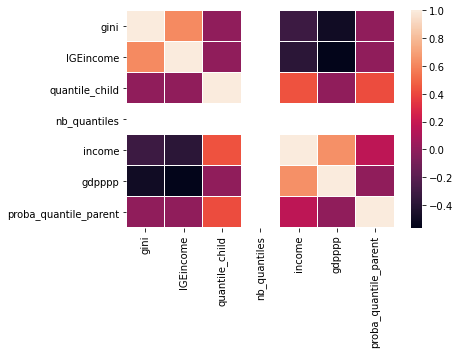

In [37]:
# 1. vérifiez la collinéarité des variables explicatives
Q2.corr()
sns.heatmap(Q2.corr(),linewidths=0.1)
plt.savefig('bi_heatmap_colinearity_Q2.png')

Parmi les variables explicatives qu'on va employer [income, gdpppp, gini], on constate qu'il existe la forte colinéarité entre gdpppp et gini, gdpppp et income, ainsi on enlève gdpppp dans ce cas. 

In [38]:
Q2=Q2.drop('gdpppp',axis=1)
Q2.corr()

,gini,IGEincome,quantile_child,nb_quantiles,income,proba_quantile_parent
gini,1.000000e+00,6.158294e-01,1.039667e-14,NaN,-0.314331,-1.052292e-14
IGEincome,6.158294e-01,1.000000e+00,-2.289996e-16,NaN,-0.382558,-1.404345e-15
quantile_child,1.039667e-14,-2.289996e-16,1.000000e+00,NaN,0.433898,4.182193e-01
nb_quantiles,NaN,NaN,NaN,NaN,NaN,NaN
income,-3.143313e-01,-3.825577e-01,4.338985e-01,NaN,1.000000,1.675381e-01
proba_quantile_parent,-1.052292e-14,-1.404345e-15,4.182193e-01,NaN,0.167538,1.000000e+00


In [39]:
income_mean_country = Q2.groupby(['country']).mean().reset_index()[['country','income']]
print(income_mean_country.info())
income_mean_country.head()

# overall mean income for the 100 quantiles as a whole country by country

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  63 non-null     object 
 1   income   63 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None


,country,income
0,ALB,2994.829902
1,AUT,16637.600204
2,BEL,15024.614176
3,BGD,998.692409
4,BIH,6334.687311


In [40]:
Linear_reg=Q2.merge(income_mean_country, 
                         left_on=['country'], 
                         right_on=['country'],
                        suffixes=('_normal', '_mean'))

print(Linear_reg.info())
Linear_reg.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150000 entries, 0 to 3149999
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   gini                   float64
 1   IGEincome              float64
 2   country                object 
 3   quantile_child         int64  
 4   nb_quantiles           int64  
 5   income_normal          float64
 6   proba_quantile_parent  int64  
 7   income_mean            float64
dtypes: float64(4), int64(3), object(1)
memory usage: 216.3+ MB
None


,gini,IGEincome,country,quantile_child,nb_quantiles,income_normal,proba_quantile_parent,income_mean
0,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902
1,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902
2,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902
3,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902
4,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902


## Multi linear regression_2 variables

In [41]:
reg_multi = smf.ols('income_normal~income_mean+gini', data=Linear_reg).fit()
reg_multi.summary()

# linear reg with multiple explicative variables : 'income_mean+gini' explain income_normal of every quantile

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          income_normal   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                 1.322e+06
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:37:33   Log-Likelihood:            -3.2857e+07
No. Observations:             3150000   AIC:                         6.571e+07
Df Residuals:                 3149997   BIC:                         6.571e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.976e-09     27.758  -3.59e-10      1.000     -54.406      54.406
income_mean     1.0000      0.001   1439.091      0.000       0.999       1.001
gini         7.773e-11      0.631   1.23e-10      1.000      -1.237       1.237
==============================================================================
Omnibus:                  3495810.153   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        499939554.028
Skew:                           5.574   Prob(JB):                         0.00
Kurtosis:                      63.703   Cond. No.                     6.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### - P-value of income_mean is 0, thus we reject H0, therefore we conclude that income_mean has impact on income_normal (income quantile by quantile) 
##### - P-value of gini is 1 (100%), thus we don't reject H0, therefore we conclude that gini has NO impact on income_normal (income quantile by quantile) 

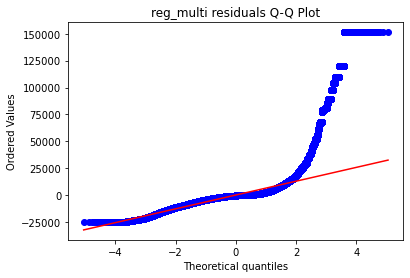

In [42]:
# 1. vérifier la normalité des résidus du model reg_multi 

stats.probplot(reg_multi.resid, dist="norm", plot= plt)
plt.title("reg_multi residuals Q-Q Plot")
plt.savefig("reg_multi_Residus_qqplot.png")

#### Grande superposition de bleue avec ligne rouge => condition normalité est valide. 

A noter qu'ici on ne stipule pas une normalité au sense stricte des résidus 

In [52]:
#2. vérifier homosétasticité des résidus par statsmodels -  reg_multi
from statsmodels.compat import lzip
import statsmodels

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

test = sms.het_breuschpagan(reg_multi.resid, reg_multi.model.exog)

lzip(name, test)

[('Lagrange multiplier statistic', 81352.84092300001),
 ('p-value', 0.0),
 ('f-value', 41754.75243071066),
 ('f p-value', 0.0)]

#### H0: présence de l'homoscétasticité des résidus
#### Lagrange multiplier statistic = 81352 très grand et le correspondant P-value = 0.0, <0.5%, rejet de H0 au niveau de test 0.5%, donc au niveau de test 0.5%, il n'existe pas de l'homoscétasticité (présence de hétéroscétasticité) pour les résidus de ce modèle reg_multi


In [62]:
analyse1=sm.stats.anova_lm(reg_multi, typ=1)
print(sum(analyse1['sum_sq']) )                          #SCT
analyse1

# type 1 suppose that there's interaction effects among independant variables , and the first-order variable is more important than the following variables 

389557848791378.1


,df,sum_sq,mean_sq,F,PR(>F)
income_mean,1.0,1.777465e+14,1.777465e+14,2.643394e+06,0.0
gini,1.0,5.456975e-13,5.456975e-13,8.115455e-21,1.0
Residual,3149997.0,2.118114e+14,6.724177e+07,NaN,NaN


In [63]:
SCE_income=analyse1.iloc[0,1]                                                 #SCR (Somme des Carrés des Résidus) 
SCE_gini=analyse1.iloc[1,1]
SCR=analyse1.iloc[2,1]                                                                 #SCR (Somme des Carrés Expliquées) 

R2_income_mean=SCE_income/sum(analyse1['sum_sq'])                # sum(analyse1['sum_sq']) = SCT  = SCE (variance expliquée par toutes les variables du modèle ou seulement par la variable en question) + SCR 

print("La variance expliquée par income_mean (soit le revenu moyen) du pays est", round(R2_income_mean*100, 2), '%')

La variance expliquée par income_mean (soit le revenu moyen) du pays est 45.63 %


In [64]:
R2_gini=SCE_gini/sum(analyse1['sum_sq']) 
print('La variance expliquée par indice Gini du pays:', round( R2_gini*100, 2), '%')

La variance expliquée par indice Gini du pays: 0.0 %


In [65]:
R2_R=SCR/sum(analyse1['sum_sq'])
print('La variance expliquée par les autres facteurs non-considérées dans modèle:', round(R2_R*100, 2), '%')

La variance expliquée par les autres facteurs non-considérées dans modèle: 54.37 %


In [66]:
R2_income_mean + R2_gini

#verification ok

0.4562775173896536


    On en conclut que:
    la variance expliquée par le revenu moyen est environ 45.6%;   
    quasi zéro par indice de Gini; 
    et par les autres facteurs non-incluses dans ce modèle est 54.4%

<font color = "#343EE4">
      - Comment réduire hétéroscédasticité ? 
      - Ici dans notre cas on peut transformer les variables en logarithme. </font>
https://www.statology.org/breusch-pagan-test-python/

## Multi linear regression_2_log

In [67]:
Linear_reg_log=Linear_reg.copy()
Linear_reg_log['log_income']=np.log(Linear_reg_log['income_normal'])
Linear_reg_log['log_income_mean']=np.log(Linear_reg_log['income_mean'])
Linear_reg_log.head()

,gini,IGEincome,country,quantile_child,nb_quantiles,income_normal,proba_quantile_parent,income_mean,log_income,log_income_mean
0,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902,6.591534,8.004643
1,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902,6.591534,8.004643
2,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902,6.591534,8.004643
3,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902,6.591534,8.004643
4,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902,6.591534,8.004643


Multicollinearity is a statistical concept where several independent variables in a model are correlated.

Two variables are considered to be perfectly collinear if their correlation coefficient is +/- 1.0.

Multicollinearity among independent variables will result in less reliable statistical inferences.

It is better to use independent variables that are not correlated or repetitive when building multiple regression models that use two or more variables.

The existence of multicollinearity in a data set can lead to less reliable results due to larger standard errors.
https://www.investopedia.com/terms/m/multicollinearity.asp#:~:text=Multicollinearity%20is%20a%20statistical%20concept,in%20less%20reliable%20statistical%20inferences


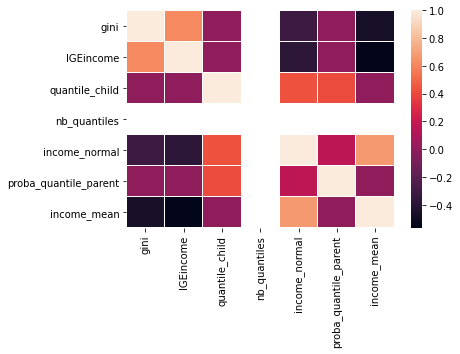

In [68]:
Linear_reg.corr()
sns.heatmap(Linear_reg.corr(),linewidths=.1)
plt.savefig('bi_heatmap_colinearity.png')

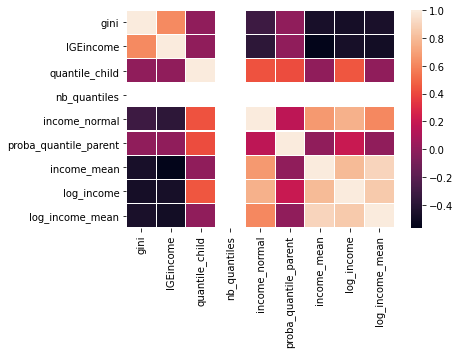

In [69]:
# . vérifiez la multicolinéarité des variables explicatives
Linear_reg_log.corr()
sns.heatmap(Linear_reg_log.corr(),linewidths=.1)
plt.savefig('bi_heatmap_colinearity_log.png')

In [70]:
reg_multi_2 = smf.ols('log_income~log_income_mean+gini', data=Linear_reg_log).fit()
reg_multi_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 4.834e+06
Date:                Fri, 11 Mar 2022   Prob (F-statistic):               0.00
Time:                        21:49:06   Log-Likelihood:            -3.4190e+06
No. Observations:             3150000   AIC:                         6.838e+06
Df Residuals:                 3149997   BIC:                         6.838e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6782      0.005    149.201      0.000       0.669       0.687
log_income_mean     0.9707      0.000   2597.477      0.000       0.970       0.971
gini               -0.0180   5.49e-05   -326.925      0.000      -0.018      -0.018
==============================================================================
Omnibus:                   320818.887   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1914508.355
Skew:                          -0.308   Prob(JB):                         0.00
Kurtosis:                       6.769   Cond. No.                         452.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

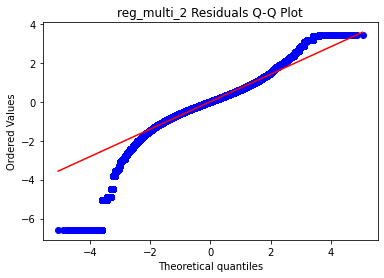

In [71]:
# 1. vérifier la normalité des résidus du model reg_multi_2

stats.probplot(reg_multi_2.resid, dist="norm", plot= plt)
plt.title("reg_multi_2 Residuals Q-Q Plot")

plt.savefig("reg_multi_2_Residus_qqplot.png")

# normalité des résidus valide 

In [96]:
# 2. vérifier homosétasticité des résidus par statsmodels -  reg_multi_2
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_multi_2.resid, reg_multi_2.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 145979.22385892624),
 ('p-value', 0.0),
 ('f-value', 76536.44090448711),
 ('f p-value', 0.0)]

#### P-value est 0, <0.5%, rejet de H0, donc il n'existe pas de l'homosétasticité (présence de l'hétéroscétasticité) pour les résidus de ce modèle reg_multi_2

In [73]:
analyse_2=sm.stats.anova_lm(reg_multi_2, typ=1)
analyse_2

,df,sum_sq,mean_sq,F,PR(>F)
log_income_mean,1.0,4.907014e+06,4.907014e+06,9.561381e+06,0.0
gini,1.0,5.485212e+04,5.485212e+04,1.068801e+05,0.0
Residual,3149997.0,1.616616e+06,5.132119e-01,NaN,NaN


In [74]:
SCE_log_income_mean=analyse_2.iloc[0,1]
SCE_gini=analyse_2.iloc[1,1]
SCR_log=analyse_2.iloc[2,1]

R2_log_income_mean=SCE_log_income_mean/sum(analyse_2['sum_sq'])
print("La variance expliquée par revenue moyen en log (log_income_mean) est de :", R2_log_income_mean*100,'%')

La variance expliquée par revenue moyen en log (log_income_mean) est de : 74.59189072396639 %


In [75]:
R2_gini2=SCE_gini/sum(analyse_2['sum_sq'])
print('La variance expliquée par Gini du pays:', R2_gini2*100, '%')

La variance expliquée par Gini du pays: 0.833811129197848 %


In [76]:
R2_SCR2 = SCR_log/sum(analyse_2['sum_sq'])
print('La variance expliquée par les résiduels: ', R2_SCR2*100, '%')

La variance expliquée par les résiduels:  24.57429814683577 %


In [77]:
#verification 

R2_log_income_mean+ R2_gini2                    # result equals to the R-squared, ok 

0.7542570185316423

    On en conclut que la variance expliquée par le revenu moyen en log est environ 74.6%; 
    0.8 % par indice de Gini; 
    et par les autres facteurs non-incluses dans ce modèle est 24.6%

### En incluant les classes de revenus des parents dans les variables explicatives:

## Multi linear regression_3 variables explicatives

In [135]:
reg_multi_3 = smf.ols('income_normal~income_mean+gini+proba_quantile_parent', data=Linear_reg_log).fit()
reg_multi_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          income_normal   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 9.862e+05
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:38:31   Log-Likelihood:            -3.2774e+07
No. Observations:             3150000   AIC:                         6.555e+07
Df Residuals:                 3149996   BIC:                         6.555e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3259.4773     28.155   -115.768      0.000   -3314.661   -3204.294
income_mean               1.0000      0.001   1477.739      0.000       0.999       1.001
gini                   7.824e-11      0.614   1.27e-10      1.000      -1.204       1.204
proba_quantile_parent    64.5441      0.156    414.085      0.000      64.239      64.850
==============================================================================
Omnibus:                  3537135.379   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        540107613.415
Skew:                           5.668   Prob(JB):                         0.00
Kurtosis:                      66.140   Cond. No.                     7.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

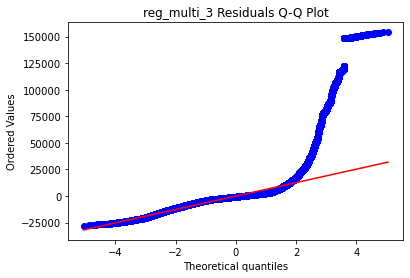

In [136]:
# 1. vérifier la normalité des résidus du model reg_multi_3

stats.probplot(reg_multi_3.resid, dist="norm", plot= plt)
plt.title("reg_multi_3 Residuals Q-Q Plot")
plt.savefig("reg_multi_3 Residus_qqplot.png")

In [137]:
# 2. vérifier homosétasticité des résidus par statsmodels -  reg_multi_3
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_multi_3.resid, reg_multi_3.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 90355.6983633005),
 ('p-value', 0.0),
 ('f-value', 31007.971337207444),
 ('f p-value', 0.0)]

#### P-value est 0, <0.5%, rejet de H0, donc il n'existe pas de l'homosétasticité (présence de l'hétéroscétasticité) pour les résidus de ce modèle reg_multi_3

In [82]:
analyse3=sm.stats.anova_lm(reg_multi_3, typ=1)
analyse3

,df,sum_sq,mean_sq,F,PR(>F)
income_mean,1.0,1.777465e+14,1.777465e+14,2.787283e+06,0.0
gini,1.0,5.456975e-13,5.456975e-13,8.557208e-21,1.0
proba_quantile_parent,1.0,1.093450e+13,1.093450e+13,1.714664e+05,0.0
Residual,3149996.0,2.008769e+14,6.377051e+07,NaN,NaN


In [83]:
SCE_income_mean=analyse3.iloc[0,1]
SCE_gini=analyse3.iloc[1,1]
SCE_class_p=analyse3.iloc[2,1]
SCR_3=analyse3.iloc[3,1]

R2_classe_parent=SCE_class_p/sum(analyse3['sum_sq'])
R2_income_mean = SCE_income_mean/sum(analyse3['sum_sq'])
R2_SCR3 = SCR_3/sum(analyse3['sum_sq'])
R2_gini3= SCE_gini/sum(analyse3['sum_sq'])

print('La variance expliquée par la classe de revenu des parents est de :', round(R2_classe_parent*100,2), '%')
print('La variance expliquée par le revenu moyen du pays est de :', round(R2_income_mean*100,2),'%')
print('La variance expliquée par Gini du pays:', round(R2_gini3*100,2), '%')
print('La variance expliquée par les autres facteurs est de :', round(R2_SCR3*100,2), '%')

La variance expliquée par la classe de revenu des parents est de : 2.81 %
La variance expliquée par le revenu moyen du pays est de : 45.63 %
La variance expliquée par Gini du pays: 0.0 %
La variance expliquée par les autres facteurs est de : 51.57 %


In [84]:
R2_classe_parent + R2_income_mean  +  R2_gini3

# verification ok

0.4843465270857672

## Multi linear regression_3_log

In [141]:
reg_multi_3_log= smf.ols('log_income~log_income_mean+gini+proba_quantile_parent', data=Linear_reg_log).fit()
reg_multi_3_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                 4.141e+06
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:00:02   Log-Likelihood:            -3.1124e+06
No. Observations:             3150000   AIC:                         6.225e+06
Df Residuals:                 3149996   BIC:                         6.225e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1511      0.004     36.195      0.000       0.143       0.159
log_income_mean           0.9707      0.000   2863.028      0.000       0.970       0.971
gini                     -0.0180   4.98e-05   -360.348      0.000      -0.018      -0.018
proba_quantile_parent     0.0104   1.27e-05    822.800      0.000       0.010       0.010
==============================================================================
Omnibus:                   348378.084   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2099750.184
Skew:                          -0.363   Prob(JB):                         0.00
Kurtosis:                       6.933   Cond. No.                         781.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

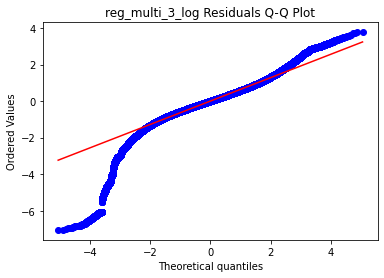

In [89]:
# 1. vérifier la normalité des résidus du model reg_multi_3_log

stats.probplot(reg_multi_3_log.resid, dist="norm", plot= plt)
plt.title("reg_multi_3_log Residuals Q-Q Plot")
plt.savefig("reg_multi_3_log Residus_qqplot.png")

In [129]:
# 2. vérifier homosétasticité des résidus par statsmodels -  reg_multi_3_log
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_multi_3_log.resid, reg_multi_3_log.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 101338.99782132792),
 ('p-value', 0.0),
 ('f-value', 34902.474403579006),
 ('f p-value', 0.0)]

#### P-value = 0.0, <0.5%, rejet de H0 au niveau de test 0.5%, il n'existe pas de l'homosétasticité pour les résidus de ce modèle reg_multi_3_log

In [130]:
analyse4=sm.stats.anova_lm(reg_multi_3_log, typ=1)
analyse4

,df,sum_sq,mean_sq,F,PR(>F)
log_income_mean,1.0,4.907014e+06,4.907014e+06,1.161632e+07,0.0
gini,1.0,5.485212e+04,5.485212e+04,1.298508e+05,0.0
proba_quantile_parent,1.0,2.859814e+05,2.859814e+05,6.770005e+05,0.0
Residual,3149996.0,1.330634e+06,4.224242e-01,NaN,NaN


In [131]:
SCE_income_mean_log=analyse4.iloc[0,1]
SCE_gini4=analyse4.iloc[1,1]
SCE_class_p=analyse4.iloc[2,1]
SCR_4=analyse4.iloc[3,1]

R2_classe_p=SCE_class_p/sum(analyse4['sum_sq'])
R2_incomemean_log= SCE_income_mean_log/sum(analyse4['sum_sq'])
R2_gini4 = SCE_gini4/sum(analyse4['sum_sq'])
R2_SCR4 = SCR_4/sum(analyse4['sum_sq']) 

print('La variance expliquée par la classe de revenu des parents est de :', round(R2_classe_p*100,2), '%')
print('La variance expliquée par le revenu moyen en log est de :', round(R2_incomemean_log*100,2), '%')
print('La variance expliquée par lindice Gini est de :', round(R2_gini4*100,2), '%')
print('La variance expliquée par les autres facteurs est de :', round(R2_SCR4*100,2), '%')


La variance expliquée par la classe de revenu des parents est de : 4.35 %
La variance expliquée par le revenu moyen en log est de : 74.59 %
La variance expliquée par lindice Gini est de : 0.83 %
La variance expliquée par les autres facteurs est de : 20.23 %


Autrement dit, en terme de logarithme, sur le revenu des enfants (log_income): 

    - la classe de revenu des parents a 4.35 % d'influence
    - le revenu moyen du pays (en log) a 74.59 % d'influence
    - indice Gini du pays en joue 0.83 % 
    - les autres facteurs aléatoires en jouent 20.23 % 

In [93]:
R2_gini4 +  R2_incomemean_log + R2_classe_p

#verification ok 

0.7977292596010751

In [142]:
# méthode fit() pour prendre en compte l'impact de hétéroscétasticité 
reg_multi_3_logfit= smf.ols('log_income~log_income_mean+gini+proba_quantile_parent', data=Linear_reg_log).fit(cov_type='HC3')
reg_multi_3_logfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                 4.733e+06
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:05:30   Log-Likelihood:            -3.1124e+06
No. Observations:             3150000   AIC:                         6.225e+06
Df Residuals:                 3149996   BIC:                         6.225e+06
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1511      0.005     31.607      0.000       0.142       0.160
log_income_mean           0.9707      0.000   2777.395      0.000       0.970       0.971
gini                     -0.0180   6.52e-05   -275.243      0.000      -0.018      -0.018
proba_quantile_parent     0.0104   1.36e-05    767.066      0.000       0.010       0.010
==============================================================================
Omnibus:                   348378.084   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2099750.184
Skew:                          -0.363   Prob(JB):                         0.00
Kurtosis:                       6.933   Cond. No.                         781.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

<font color="purple"> Le coefficient de régression indique dans quelle mesure la valeur d'une variable dépendante varie avec la variation de la valeur de la variable indépendante (aussi appelée variable explicative). 

L'intercept (= ordonnée à l'origine) est la valeur obtenue lorsque la variable indépendante vaut zéro (voir figure 1). </font>


In [94]:
Linear_reg_log.head(1)

,gini,IGEincome,country,quantile_child,nb_quantiles,income_normal,proba_quantile_parent,income_mean,log_income,log_income_mean
0,31.408889,0.815874,ALB,1,100,728.89795,1,2994.829902,6.591534,8.004643


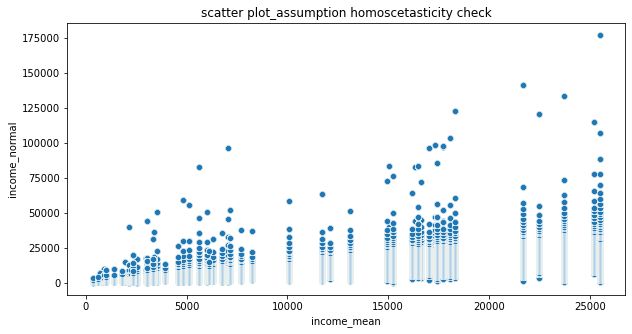

In [121]:
plt.figure(figsize= (10,5))
sns.scatterplot(data=Linear_reg_log, x="income_mean", y="income_normal")
plt.title("scatter plot_assumption homoscetasticity check")
plt.savefig('P7M4_scatter plot_assumption homoscetasticity check.png')

## Si l'on fait linear regression sur l'échantillon d'un pays?
Ici on prend l'exemple ALB

In [109]:
ALB.head()
ALB_reg= ALB.copy()
ALB_reg['income_mean']= ALB_reg['income'].mean()
ALB_reg['log_income'] =np.log(ALB_reg['income'])
ALB_reg['log_income_mean'] =np.log(ALB_reg['income_mean'])
ALB_reg.head()

,gini,IGEincome,country,quantile_child,nb_quantiles,income,gdpppp,proba_quantile_parent,income_mean,log_income,log_income_mean
0,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1,2994.829902,6.591534,8.004643
6300,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1,2994.829902,6.591534,8.004643
12600,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1,2994.829902,6.591534,8.004643
18900,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1,2994.829902,6.591534,8.004643
25200,31.408889,0.815874,ALB,1,100,728.89795,7297.0,1,2994.829902,6.591534,8.004643


In [111]:
reg_ALB =  smf.ols('log_income~log_income_mean+gini+proba_quantile_parent', data=ALB_reg).fit(cov_type='HC3')
reg_ALB.summary()

# méthode .fit(cov_type='HC3') aide à réduire l'effect de l'hétéroscétasticité 

/Users/ZoeyZhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_income   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.151e+15
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:41:18   Log-Likelihood:                -27059.
No. Observations:               50000   AIC:                         5.412e+04
Df Residuals:                   49997   BIC:                         5.415e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.291e+08      9.703   3.39e+07      0.000    3.29e+08    3.29e+08
log_income_mean        5.637e+09    166.163   3.39e+07      0.000    5.64e+09    5.64e+09
gini                  -1.447e+09     42.656  -3.39e+07      0.000   -1.45e+09   -1.45e+09
proba_quantile_parent     0.0110      2e-12   5.53e+09      0.000       0.011       0.011
==============================================================================
Omnibus:                     2778.436   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4262.285
Skew:                           0.479   Prob(JB):                         0.00
Kurtosis:                       4.062   Cond. No.                     7.86e+19
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 3.42e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

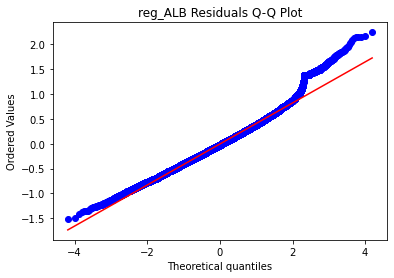

In [113]:
# 1. vérifier la normalité des résidus du model reg_ALB
stats.probplot(reg_ALB.resid, dist="norm", plot= plt)
plt.title("reg_ALB Residuals Q-Q Plot")
plt.savefig("reg_ALB Residus_qqplot.png")

=> normalité quasi parfaite pour les résidus du modèle reg_ALB

In [112]:
# 2. vérifier homosétasticité des résidus par statsmodels reg_ALB

test = sms.het_breuschpagan(reg_ALB.resid, reg_ALB.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 649.0151053177129),
 ('p-value', 2.38174700496322e-140),
 ('f-value', 328.7554269668309),
 ('f p-value', 1.4256401060724296e-142)]

#### Lagrange multiplier statistic est petit et sa P-value = 2.38 > 5%, non-rejet de H0 au niveau de test 5%, il existe de l'homosétasticité pour les résidus de ce modèle reg_ALB


In [123]:
analyse_ALB=sm.stats.anova_lm(reg_ALB, typ=1)
analyse_ALB

,df,sum_sq,mean_sq,F,PR(>F)
log_income_mean,1.0,1.588086,1.588086,9.188968,0.002436
gini,1.0,1.588150,1.588150,9.189336,0.002436
proba_quantile_parent,1.0,5081.766626,5081.766626,29404.060971,0.000000
Residual,49997.0,8640.748168,0.172825,NaN,NaN


In [126]:
SCE_income_mean_log5=analyse_ALB.iloc[0,1]
SCE_gini5=analyse_ALB.iloc[1,1]
SCE_class_p5=analyse_ALB.iloc[2,1]
SCR_5=analyse_ALB.iloc[3,1]

R2_classe_p5=SCE_class_p5/sum(analyse_ALB['sum_sq'])
R2_incomemean_log5= SCE_income_mean_log5/sum(analyse_ALB['sum_sq'])
R2_gini5 = SCE_gini5/sum(analyse_ALB['sum_sq'])
R2_SCR5 = SCR_5/sum(analyse_ALB['sum_sq']) 

print('Décomposition de variance totale expliquée_pays ALB: ')
print('La variance expliquée par la classe de revenu des parents est de :', round(R2_classe_p5*100,2), '%')
print('La variance expliquée par le revenu moyen en log est de :', round(R2_incomemean_log5*100,2), '%')
print('La variance expliquée par lindice Gini est de :', round(R2_gini5*100,2), '%')
print('La variance expliquée par les autres facteurs est de :', round(R2_SCR5*100,2), '%')

Décomposition de variance totale expliquée_pays ALB: 
La variance expliquée par la classe de revenu des parents est de : 37.02 %
La variance expliquée par le revenu moyen en log est de : 0.01 %
La variance expliquée par lindice Gini est de : 0.01 %
La variance expliquée par les autres facteurs est de : 62.95 %


In [95]:
# End